In [3]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

## Processing dataset to obtain relevant gestures

In [14]:
current_dataset = {}
with open('model/keypoint_classifier/keypoint.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        gesture_id = int(row[0])
        if gesture_id not in current_dataset:
            current_dataset[gesture_id] = []
        
        current_dataset[gesture_id].append(row[1:])

In [17]:
for gesture in current_dataset.keys():
    print(len(current_dataset[gesture]))
    
print()
    
with open('model/keypoint_classifier/keypoint_processed.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    current_gesture = 0
    for gesture in current_dataset.keys():
        if gesture != 5:
            for sample in current_dataset[gesture]:
                writer.writerow([str(current_gesture)] + sample)
            
            current_gesture += 1

new_dataset = {}
with open('model/keypoint_classifier/keypoint_processed.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        gesture_id = int(row[0])
        if gesture_id not in new_dataset:
            new_dataset[gesture_id] = []
        
        new_dataset[gesture_id].append(row[1:])

for gesture in new_dataset.keys():
    print(len(new_dataset[gesture]))

1595
1663
1510
672
164
257
139
190

1595
1663
1510
672
164
139
190


# Specify each path

In [10]:
# Specify data paths
dataset = 'model/keypoint_classifier/keypoint_processed.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
# Change training classes if necessary
NUM_CLASSES = 7

# Dataset reading

In [20]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [21]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6]), array([1595, 1663, 1510,  672,  164,  139,  190], dtype=int64))


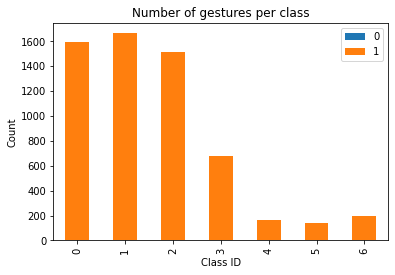

In [29]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
graph = df.T.plot(kind="bar", stacked=True, title='Number of gestures per class')
graph.set_xlabel("Class ID")
graph.set_ylabel("Count")
print(counts)

# Model building

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [24]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 42)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                1376      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 7)                

In [25]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [26]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [27]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
53/65 [=======================>......] - ETA: 0s - loss: 1.7198 - accuracy: 0.3328
Epoch 00001: val_loss improved from inf to 1.31104, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
65/65 [==============================] - 2s 13ms/step - loss: 1.6627 - accuracy: 0.3441 - val_loss: 1.3110 - val_accuracy: 0.5303
Epoch 2/1000
62/65 [===========================>..] - ETA: 0s - loss: 1.0141 - accuracy: 0.7054
Epoch 00002: val_loss improved from 1.31104 to 0.70686, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
65/65 [==============================] - 0s 7ms/step - loss: 1.0009 - accuracy: 0.7098 - val_loss: 0.7069 - val_accuracy: 0.8309
Epoch 3/1000
61/65 [===========================>..] - ETA: 0s - loss: 0.5196 - accuracy: 0.8648
Epoch 00003: val_loss improved from 0.70686 to 0.36997, saving model to model/keypoint_classifier\keypoint_classifier.hdf5
65/65 [==============================] - 0s 7ms/step - loss: 0.5125 - accuracy: 0.8661 -

In [28]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [29]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

28/28 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9966


In [30]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.9998116e-01 1.9555956e-07 1.8631601e-05 4.9263099e-10 8.1802013e-12
 5.5178467e-10 2.4716714e-14]
0


# Confusion matrix

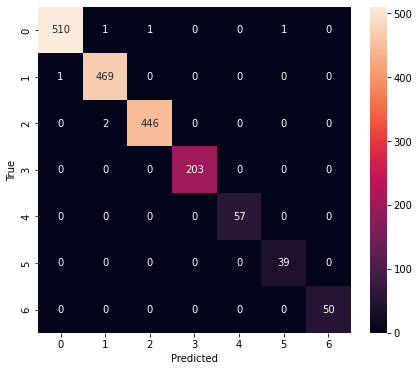

Classification Report
              precision    recall  f1-score   support

           0     0.9980    0.9942    0.9961       513
           1     0.9936    0.9979    0.9958       470
           2     0.9978    0.9955    0.9966       448
           3     1.0000    1.0000    1.0000       203
           4     1.0000    1.0000    1.0000        57
           5     0.9750    1.0000    0.9873        39
           6     1.0000    1.0000    1.0000        50

    accuracy                         0.9966      1780
   macro avg     0.9949    0.9982    0.9965      1780
weighted avg     0.9966    0.9966    0.9966      1780



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    plt.xlabel('True Class')
    plt.xlabel('Predicted Class')
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    ax.set(xlabel='Predicted', ylabel='True')
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred, digits=4))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [33]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [34]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\halor\AppData\Local\Temp\tmpxd9uxaud\assets


7632

## Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

## Download model

In [ ]:
!zip -r model.zip keypoint_classifier  



---


# ❗️Hyperparameters Tuning

In [1]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [2]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [5]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [6]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

NameError: name 'model_save_path' is not defined

In [ ]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

In [ ]:
# !ATTENTION! Works only in Colab
# %tensorboard --logdir logs/hparam_tuning

In [17]:
!rm -rf logs

'rm' is not recognized as an internal or external command,
operable program or batch file.
